### Домашка

In [4]:
!pip install gensim

import gensim
from gensim import corpora
from gensim.models import TfidfModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 95.1 MB/s eta 0:00:00


1. Скачать [датасет по ссылке](https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv) (просто запустить строку ниже)

In [2]:
!wget https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv

--2025-12-16 09:46:29--  https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102826 (100K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>] 100.42K  --.-KB/s    in 0.02s   

2025-12-16 09:46:29 (6.37 MB/s) - ‘test.csv’ saved [102826/102826]



2. Открыть csv и сохранить текст в переменную (макс. балл == 1)

In [5]:
df = pd.read_csv('test.csv', encoding='utf8')

3. Извлечь столбец с текстами (макс. балл == 1)

In [6]:
texts = df['text'].tolist()

4. Построить Bag-of-Words (макс. балл == 3)

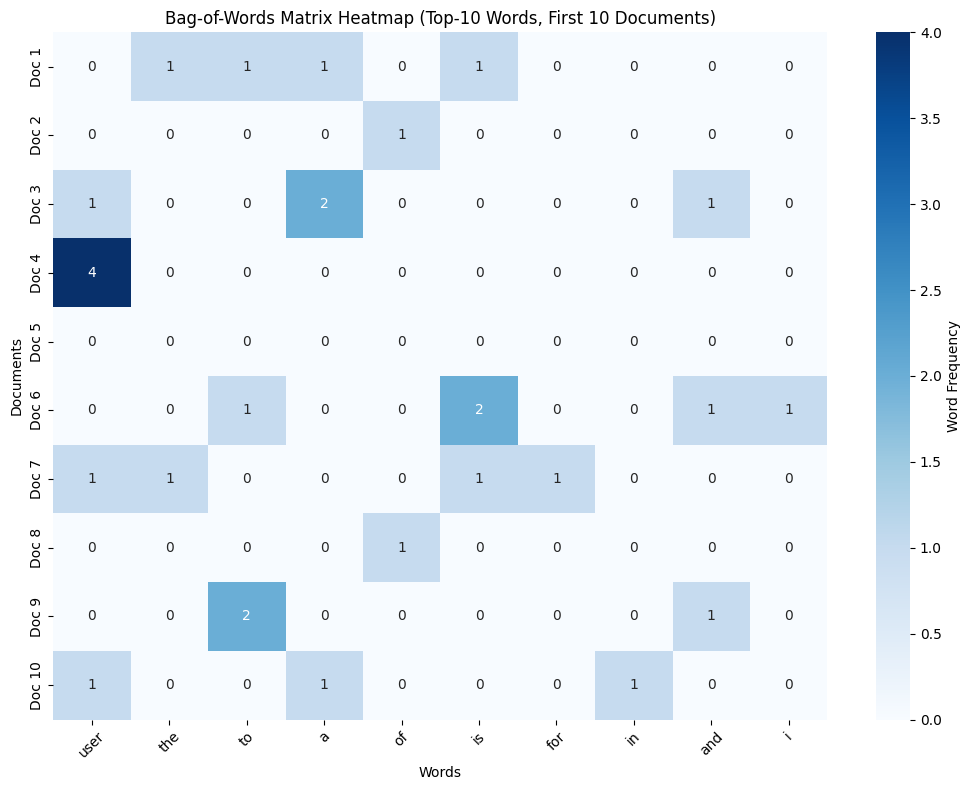

In [9]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token]
    return tokens

tokenized_texts = [preprocess_text(text) for text in texts]
dictionary = corpora.Dictionary(tokenized_texts)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_texts]

def bow_to_dense(bow_corpus, dictionary):
    dense_vectors = []
    for doc in bow_corpus:
        dense_vec = [0] * len(dictionary)
        for idx, freq in doc:
            dense_vec[idx] = freq
        dense_vectors.append(dense_vec)
    return dense_vectors

dense_vectors = bow_to_dense(bow_corpus, dictionary)

from collections import Counter

all_tokens = []
for tokens in tokenized_texts:
    all_tokens.extend(tokens)

word_freq_counter = Counter(all_tokens)

top_10_words = [word for word, freq in word_freq_counter.most_common(10)]

word_indices = [dictionary.token2id[word] for word in top_10_words]
matrix_top10 = np.array(dense_vectors)[:10, word_indices]
doc_names = [f"Doc {i+1}" for i in range(10)]
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.heatmap(matrix_top10,
            annot=True,
            fmt='d',
            xticklabels=top_10_words,
            yticklabels=doc_names,
            cmap='Blues',
            cbar_kws={'label': 'Word Frequency'})
plt.title('Bag-of-Words Matrix Heatmap (Top-10 Words, First 10 Documents)')
plt.xticks(rotation=45)
plt.ylabel('Documents')
plt.xlabel('Words')

plt.tight_layout()
plt.show()

5. Построить TF-IDF (макс. балл == 5)

In [15]:
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]



# Задача 2.2: Проанализируйте веса TF-IDF (макс. балл == 3)

def analyze_tfidf_components(bow_corpus, dictionary, tokenized_texts):
    N = len(bow_corpus)

    tf_matrix = np.zeros((len(bow_corpus), len(dictionary)))
    for doc_idx, doc in enumerate(bow_corpus):
        for word_idx, freq in doc:
            tf_matrix[doc_idx, word_idx] = freq

    doc_lengths = [len(tokens) for tokens in tokenized_texts]
    for doc_idx in range(len(bow_corpus)):
        if doc_lengths[doc_idx] > 0:
            tf_matrix[doc_idx, :] = tf_matrix[doc_idx, :] / doc_lengths[doc_idx]

    df_vector = np.sum(tf_matrix > 0, axis=0)
    idf_vector = np.log(N / (df_vector + 1)) + 1
    tfidf_manual = tf_matrix * idf_vector

    return tf_matrix, df_vector, idf_vector, tfidf_manual

tf_matrix, df_vector, idf_vector, tfidf_manual = analyze_tfidf_components(bow_corpus, dictionary, tokenized_texts)

analysis_data = [
    {
        'word': word,
        'document_frequency': df_vector[dictionary.token2id[word]],
        'idf': idf_vector[dictionary.token2id[word]],
        'tf_example': tf_matrix[0, dictionary.token2id[word]],
        'tfidf_example': tfidf_manual[0, dictionary.token2id[word]]
    }
    for word in dictionary.token2id.keys()
]

analysis_df = pd.DataFrame(analysis_data)
analysis_df.to_csv('tfidf_analysis.csv', index=False, encoding='utf-8')

6. Произвести сравнение

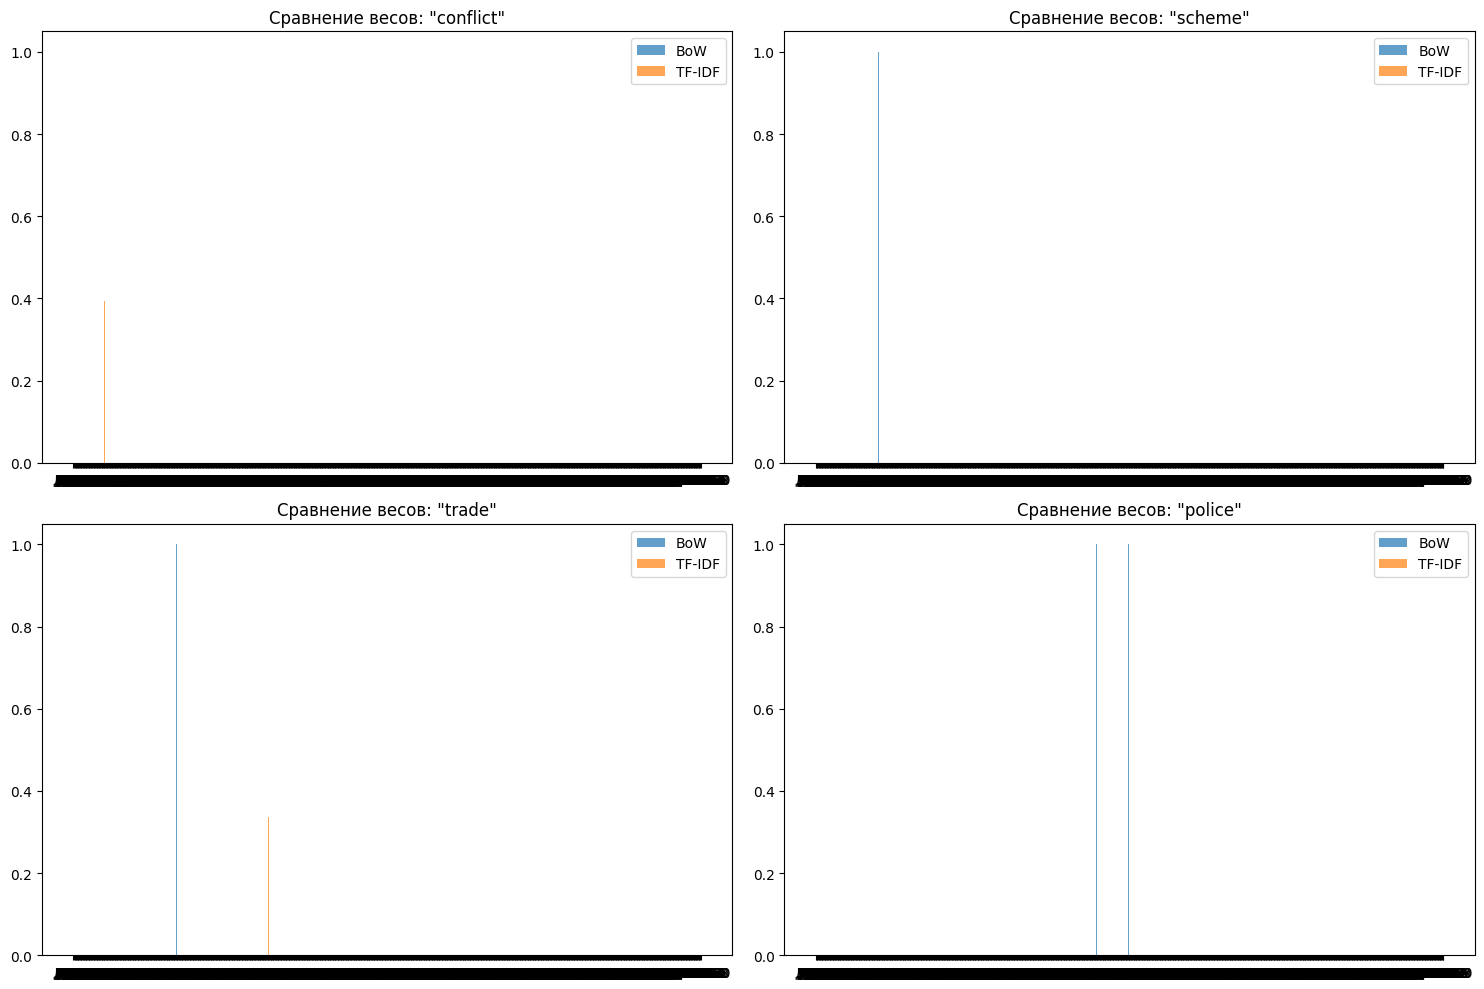

In [20]:
def tfidf_to_dense(tfidf_corpus, dictionary):
    dense_vectors = []
    for doc in tfidf_corpus:
        dense_vec = [0.0] * len(dictionary)
        for idx, score in doc:
            dense_vec[idx] = score
        dense_vectors.append(dense_vec)
    return dense_vectors

tfidf_dense = tfidf_to_dense(tfidf_corpus, dictionary)

def compare_bow_tfidf(words, bow_dense, tfidf_dense, dictionary):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, word in enumerate(words):
        row, col = i // 2, i % 2
        word_id = dictionary.token2id[word]

        bow_weights = [doc[word_id] for doc in bow_dense]
        tfidf_weights = [doc[word_id] for doc in tfidf_dense]

        x = range(len(bow_dense))
        axes[row, col].bar(x, bow_weights, alpha=0.7, label='BoW', width=0.4)
        axes[row, col].bar([p + 0.4 for p in x], tfidf_weights, alpha=0.7, label='TF-IDF', width=0.4)
        axes[row, col].set_title(f'Сравнение весов: "{word}"')
        axes[row, col].legend()
        axes[row, col].set_xticks([p + 0.2 for p in x])
        axes[row, col].set_xticklabels([f'Док {i+1}' for i in x])

    plt.tight_layout()
    plt.show()

characteristic_words = ['conflict', 'scheme', 'trade', 'police']
compare_bow_tfidf(characteristic_words, dense_vectors, tfidf_dense, dictionary)